In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import deque

import os
import numpy as np
import pandas as pd
import random
import time
import requests

In [2]:
# This is to choose which GPU to use. Set to -1 for no GPU
# If using Colab comment out this code
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
import subprocess 
import tempfile 

In [4]:
# If using Colab put the files on your Drive account and uncomment this code. 
#Follow the instructions after running block

#from google.colab import drive
#drive.mount('/content/gdrive')

In [5]:
print(tf.config.experimental.list_physical_devices(device_type='GPU'))
print(tf.test.gpu_device_name())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
for d in physical_devices:
    try:
        tf.config.experimental.set_memory_growth(d, True)
    except:
        pass

try:
    print(tf.config.experimental.get_device_details(physical_devices[0]))
except:
    print("No GPU")

{'device_name': 'GeForce GTX 1660 Ti', 'compute_capability': (7, 5)}


In [7]:
# The csv files will need to be located in folder MY_PATH/archive
#MY_PATH = './gdrive/MyDrive/project/'
MY_PATH = ''
FILE_NAME = MY_PATH + 'archive/' + 'BTCUSDT_2017.csv'
MULTIYEAR = False

In [8]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(315)
tf.random.set_seed(315)
random.seed(315)

In [9]:
# Window size or the sequence length
N_STEPS = 20
# Lookup step, 1 is the next day
LOOKUP_STEP = 5

# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
# whether to shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"
# whether to split the training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
#FEATURE_COLUMNS = ["close", "open", "high", "low"]
FEATURE_COLUMNS = ["close"]
# date now
date_now = time.strftime("%Y-%m-%d")

### model parameters

N_LAYERS = 2
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 128
# 40% dropout
DROPOUT = 0.3
# whether to use bidirectional RNNs
BIDIRECTIONAL = True

### training parameters

# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 128 # originally 64
EPOCHS = 20 # originally 500

# Amazon stock market
ticker = "BTC"
ticker_data_filename = os.path.join(MY_PATH + "data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-\
units-{UNITS}-epochs-{EPOCHS}-batchsize-{BATCH_SIZE}-dropout-{DROPOUT * 100:.0f}"
if BIDIRECTIONAL:
    model_name += "-b"

In [10]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)


#def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
#                test_size=0.2, feature_columns=['close', 'volume', 'open', 'high', 'low']):
def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=FEATURE_COLUMNS, multiyear=False, file_name=FILE_NAME):

    df1 = pd.read_csv(file_name)
    
    if multiyear and FILE_NAME == MY_PATH + 'archive/' + 'BTCUSDT_2017.csv':
        df2 = pd.read_csv(MY_PATH + 'archive/' +'BTCUSDT_2018.csv')
        df3 = pd.read_csv(MY_PATH + 'archive/' +'BTCUSDT_2019.csv')
        df4 = pd.read_csv(MY_PATH + 'archive/' +'BTCUSDT_2020.csv')
        df = df1.append([df2, df3, df4], ignore_index=True)
    elif multiyear and FILE_NAME == MY_PATH + 'archive/ETHUSDT_2017.csv':
        df2 = pd.read_csv(MY_PATH + 'archive/' +'ETHUSDT_2018.csv')
        df3 = pd.read_csv(MY_PATH + 'archive/' +'ETHUSDT_2019.csv')
        df4 = pd.read_csv(MY_PATH + 'archive/' +'ETHUSDT_2020.csv')
        df = df1.append([df2, df3, df4], ignore_index=True)
    else:
        df = df1
    
    #df['date'] = pd.to_datetime(df['date'], unit='s')

    print(df)
    #print(df.columns)


    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()

    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."

    df.drop(['date'], axis=1, inplace=True)

    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index


    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler

        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler

    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['close'].shift(-lookup_step)

    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    
    # drop NaNs
    df.dropna(inplace=True)

    sequence_data = []
    sequences = deque(maxlen=n_steps)

    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])

    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)

    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)

    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)

    return result

In [11]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_squared_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
        #model.add(BatchNormalization())
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error", "mean_squared_error"], optimizer=optimizer)
    return model

In [12]:
# create these folders if they does not exist
if not os.path.isdir(MY_PATH + "results"):
    os.mkdir(MY_PATH + "results")

if not os.path.isdir(MY_PATH + "logs"):
    os.mkdir(MY_PATH + "logs")

if not os.path.isdir(MY_PATH + "data"):
    os.mkdir(MY_PATH + "data")
#print("One")
# load the data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS, multiyear=MULTIYEAR, file_name=FILE_NAME)
#print("Two")
# save the dataframe
data["df"].to_csv(ticker_data_filename)
#print("Three")
# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

model.summary()

              date       low      high      open     close    volume
0       1502942400   4261.48   4261.48   4261.48   4261.48  1.775183
1       1502942460   4261.48   4261.48   4261.48   4261.48  0.000000
2       1502942520   4280.56   4280.56   4280.56   4280.56  0.261074
3       1502942580   4261.48   4261.48   4261.48   4261.48  0.012008
4       1502942640   4261.48   4261.48   4261.48   4261.48  0.140796
...            ...       ...       ...       ...       ...       ...
196541  1514764500  13685.00  13695.52  13653.76  13695.52  5.565341
196542  1514764560  13695.52  13741.81  13668.06  13741.81  3.618499
196543  1514764620  13734.29  13741.82  13697.05  13734.27  1.777407
196544  1514764680  13734.27  13741.00  13706.61  13740.96  1.014558
196545  1514764740  13740.96  13741.00  13697.61  13716.36  4.939606

[196546 rows x 6 columns]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Para

In [13]:
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join(MY_PATH + "results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join(MY_PATH + "logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Epoch 1/20
1229/1229 [==============================] - 59s 40ms/step - loss: 3.2759e-04 - mean_absolute_error: 0.0126 - mean_squared_error: 6.5518e-04 - val_loss: 8.9552e-06 - val_mean_absolute_error: 0.0022 - val_mean_squared_error: 1.7910e-05

Epoch 00001: val_loss improved from inf to 0.00001, saving model to results\2021-08-07_BTC-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-20-step-5-layers-2-units-128-epochs-20-batchsize-128-dropout-30-b.h5
Epoch 2/20
1229/1229 [==============================] - 50s 41ms/step - loss: 1.3411e-04 - mean_absolute_error: 0.0094 - mean_squared_error: 2.6823e-04 - val_loss: 1.5337e-05 - val_mean_absolute_error: 0.0033 - val_mean_squared_error: 3.0673e-05

Epoch 00002: val_loss did not improve from 0.00001
Epoch 3/20
1229/1229 [==============================] - 40s 33ms/step - loss: 1.0586e-04 - mean_absolute_error: 0.0085 - mean_squared_error: 2.1172e-04 - val_loss: 1.2275e-05 - val_mean_absolute_error: 0.0031 - val_mean_squared_error: 2.4549e-05

Epoch 0

In [154]:
import matplotlib.pyplot as plt

def plot_graph(test_df):
    """
    This function plots true close price along with predicted close price
    with blue and red colors respectively
    """
    plt.plot(test_df[f'true_close_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'close_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Periods")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

In [15]:
def get_final_df(model, data):
    """
    This function takes the `model` and `data` dict to 
    construct a final dataframe that includes the features along 
    with true and predicted prices of the testing dataset
    """
    # if predicted future price is higher than the current, 
    # then calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0
    
    buy_profit_percent  = lambda current, pred_future, true_future: (true_future - current) / current if pred_future > current else 0
    sell_profit_percent = lambda current, pred_future, true_future: (current - true_future) / current if pred_future < current else 0
    #buy_profit_percent  = lambda current, pred_future, true_future: (true_future - current) / current if (pred_future - current)/current > 0.002 else 0
    #sell_profit_percent = lambda current, pred_future, true_future: (current - true_future) / current if (pred_future - current)/current < -0.002 else 0
    
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["close"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["close"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"close_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_close_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["close"], 
                                    final_df[f"close_{LOOKUP_STEP}"], 
                                    final_df[f"true_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["close"], 
                                    final_df[f"close_{LOOKUP_STEP}"], 
                                    final_df[f"true_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the buy profit column
    final_df["buy_profit_percent"] = list(map(buy_profit_percent, 
                                    final_df["close"], 
                                    final_df[f"close_{LOOKUP_STEP}"], 
                                    final_df[f"true_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit_percent"] = list(map(sell_profit_percent, 
                                    final_df["close"], 
                                    final_df[f"close_{LOOKUP_STEP}"], 
                                    final_df[f"true_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

In [16]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    print(f'shape:     {last_sequence.shape}')
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["close"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [17]:
# Specify model name from previosly trained model
#model_name = '2021-06-06_BTC-sh-1-sc-0-sbd-0-huber_loss-adam-LSTM-seq-20-step-5-layers-2-units-256-epochs-20-batchsize-128-dropout-30.0-b'

In [18]:
# load optimal model weights from results folder
model_path = os.path.join(MY_PATH + "results", model_name) + ".h5"
model.load_weights(model_path)

In [19]:
# evaluate the model
loss, mae, mse = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["close"].inverse_transform([[mae]])[0][0]
    mean_standard_error = data["column_scaler"]["close"].inverse_transform([[mse]])[0][0]
else:
    mean_absolute_error = mae
    mean_standard_error = mse

In [20]:
# get the final dataframe for the testing set
final_df = get_final_df(model, data)

In [21]:
# predict the future price
future_price = predict(model, data)

shape:     (20, 1)


In [22]:
# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
percent_buys = (len(final_df[final_df['buy_profit'] > 0]) + len(final_df[final_df['buy_profit'] < 0])) / len(final_df)
percent_sells = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['sell_profit'] < 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
total_buy_profit_percent  = final_df["buy_profit_percent"].sum()
total_sell_profit_percent = final_df["sell_profit_percent"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
total_profit_percent = total_buy_profit_percent + total_sell_profit_percent
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)
profit_per_trade_percent = total_profit_percent / len(final_df)
num_trades = len(final_df)
percent_profitable_buys = len(final_df[final_df['buy_profit'] > 0]) / (len(final_df[final_df['buy_profit'] > 0]) + len(final_df[final_df['buy_profit'] < 0]))
percent_profitable_sells = len(final_df[final_df['sell_profit'] > 0]) / (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['sell_profit'] < 0]))

In [23]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} time periods is {future_price:.2f}$")
print(f"{LOSS} loss: {loss}")
#print(f"Mean Absolute Error:", mean_absolute_error)
print(f"Mean Squared Error: {mean_standard_error:.4f}")
print(f"Accuracy score: {accuracy_score:.4f}")
print(f"Percent of buys: {percent_buys:.4f}")
print(f"Percent of sells: {percent_sells:.4f}")
print(f"Total buy profit: {total_buy_profit:.4f}")
print(f"Total sell profit: {total_sell_profit:.4f}")
print(f"Percent profitable buys: {percent_profitable_buys:.4f}")
print(f"Percent profitable sells: {percent_profitable_sells:.4f}")
print(f"Total buy profit %: {total_buy_profit_percent:.4f}")
print(f"Total sell profit %: {total_sell_profit_percent:.4f}")
print(f"Total profit: {total_profit:.4f}")
print(f"Total profit %: {total_profit_percent:.4f}")
print(f"Profit per trade: {profit_per_trade:.4f}")
print(f"Profit per trade %: {profit_per_trade_percent:.4f}")
print(f"Possible Number of trades: {num_trades}")
print(f"Number of trades: {(percent_buys + percent_sells) * num_trades:.4f}")
print(f"Steps: {N_STEPS}  Lookup Steps: {LOOKUP_STEP}   Testsize: {TEST_SIZE}   Layers: {N_LAYERS}")
print(f"Epochs: {EPOCHS}   Batchsize: {BATCH_SIZE}  Bidirectional: {BIDIRECTIONAL}")
print(f"Filename: {FILE_NAME}")
print(f"Model Name: {model_name}")
print()

money = 100
max_money = 100
min_money = 100

for i in final_df.buy_profit_percent:
    money = money * (1 + i)
    if money > max_money:
        max_money = money
    elif money < min_money:
        min_money = money
print(f"BUYING End Money: {money:.2f}     Max Money: {max_money:0.2f}     Min Money: {min_money:0.2f}")

money = 100
max_money = 100
min_money = 100

for i in final_df.sell_profit_percent:
    money = money * (1 + i)
    if money > max_money:
        max_money = money
    elif money < min_money:
        min_money = money
print(f"SHORTING End Money: {money:.2f}     Max Money: {max_money:0.2f}     Min Money: {min_money:0.2f}")

Future price after 5 time periods is 13738.33$
huber_loss loss: 7.489536073990166e-06
Mean Squared Error: 2817.2540
Accuracy score: 0.5104
Percent of buys: 0.6305
Percent of sells: 0.3066
Total buy profit: 32914.2300
Total sell profit: 24505.7300
Percent profitable buys: 0.5445
Percent profitable sells: 0.5451
Total buy profit %: 8.2532
Total sell profit %: 6.4522
Total profit: 57419.9600
Total profit %: 14.7054
Profit per trade: 1.4609
Profit per trade %: 0.0004
Possible Number of trades: 39305
Number of trades: 36834.0000
Steps: 20  Lookup Steps: 5   Testsize: 0.2   Layers: 2
Epochs: 20   Batchsize: 128  Bidirectional: True
Filename: archive/BTCUSDT_2017.csv
Model Name: 2021-08-07_BTC-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-20-step-5-layers-2-units-128-epochs-20-batchsize-128-dropout-30-b

BUYING End Money: 275827.84     Max Money: 525293.57     Min Money: 95.84
SHORTING End Money: 51884.49     Max Money: 133603.05     Min Money: 98.63


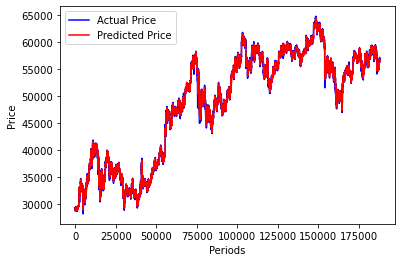

In [160]:
# plot true/pred prices graph
plot_graph(final_df)

In [25]:
final_df.head(10)

,date,low,high,open,close,volume,close_5,true_close_5,buy_profit,sell_profit,buy_profit_percent,sell_profit_percent
22.0,1502943720,4266.29,4266.29,4266.29,4266.29,0.000000,4274.463867,4266.29,0.00,0.00,0.000000,0.000000
32.0,1502944320,4274.67,4274.67,4274.67,4274.67,0.702048,4278.447754,4300.38,25.71,0.00,0.006014,0.000000
34.0,1502944440,4296.63,4296.63,4296.63,4296.63,0.952506,4281.891602,4300.38,0.00,-3.75,0.000000,-0.000873
47.0,1502945220,4310.07,4310.07,4310.07,4310.07,0.292919,4302.624023,4313.60,0.00,-3.53,0.000000,-0.000819
53.0,1502945580,4313.60,4313.61,4313.61,4313.60,0.563374,4316.384277,4308.83,-4.77,0.00,-0.001106,0.000000
64.0,1502946240,4304.31,4308.83,4308.83,4304.31,0.129580,4319.157227,4328.69,24.38,0.00,0.005664,0.000000
66.0,1502946360,4328.69,4328.69,4328.69,4328.69,0.512132,4323.551758,4328.69,0.00,0.00,0.000000,0.000000
69.0,1502946540,4328.69,4328.69,4328.69,4328.69,0.010853,4330.672852,4304.31,-24.38,0.00,-0.005632,0.000000
76.0,1502946960,4312.14,4319.99,4312.14,4319.99,4.193217,4323.076172,4320.00,0.01,0.00,0.000002,0.000000
79.0,1502947140,4320.00,4320.00,4320.00,4320.00,0.544539,4325.269043,4320.00,0.00,0.00,0.000000,0.000000


In [26]:
final_df.tail(10)

,date,low,high,open,close,volume,close_5,true_close_5,buy_profit,sell_profit,buy_profit_percent,sell_profit_percent
196489.0,1514761380,13799.98,13799.98,13777.59,13788.83,4.496518,13835.291992,13766.80,-22.03,0.00,-0.001598,0.000000
196498.0,1514761920,13737.79,13758.81,13706.68,13750.00,3.537241,13775.961914,13699.00,-51.00,0.00,-0.003709,0.000000
196503.0,1514762220,13685.77,13700.00,13666.02,13699.00,8.557351,13748.866211,13715.40,16.40,0.00,0.001197,0.000000
196506.0,1514762400,13664.74,13689.00,13653.26,13688.03,7.679417,13719.727539,13698.64,10.61,0.00,0.000775,0.000000
196508.0,1514762520,13706.68,13720.00,13672.75,13715.40,3.514558,13718.812500,13709.97,-5.43,0.00,-0.000396,0.000000
196519.0,1514763180,13799.99,13818.64,13754.25,13786.73,5.604075,13730.571289,13788.00,0.00,-1.27,0.000000,-0.000092
196521.0,1514763300,13799.97,13799.99,13732.81,13785.98,5.519148,13740.994141,13801.00,0.00,-15.02,0.000000,-0.001090
196528.0,1514763720,13778.72,13791.28,13732.89,13759.82,4.113854,13754.603516,13742.99,0.00,16.83,0.000000,0.001223
196533.0,1514764020,13745.00,13745.00,13706.17,13742.99,1.573812,13745.731445,13718.60,-24.39,0.00,-0.001775,0.000000
196539.0,1514764380,13718.54,13718.54,13685.02,13709.08,4.819266,13744.569336,13740.96,31.88,0.00,0.002325,0.000000


In [28]:
# save the final dataframe to csv-results folder
csv_results_folder = "csv-results"
if not os.path.isdir(csv_results_folder):
    os.mkdir(csv_results_folder)
csv_filename = os.path.join(csv_results_folder, model_name + ".csv")
final_df.to_csv(csv_filename)

In [29]:
#from google.colab import files

In [30]:
#files.download(model_path)
#files.download(csv_filename)

In [91]:
FILE_NAME = 'archive/BTCUSDT_2021.csv'#'archive/ETHUSDT_2021.csv' 
TEST_SIZE = 0.9999

In [92]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")

if not os.path.isdir("logs"):
    os.mkdir("logs")

if not os.path.isdir("data"):
    os.mkdir("data")
print("One")
# load the data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS, multiyear=False, file_name = FILE_NAME)
print("Two")
# save the dataframe
data["df"].to_csv(ticker_data_filename)
print("Three")
# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

model.summary()

One
              date       low      high      open     close     volume
0       1609459200  28913.12  28961.66  28923.63  28961.66  27.457032
1       1609459260  28961.01  29017.50  28961.67  29009.91  58.477501
2       1609459320  28973.58  29016.71  29009.54  28989.30  42.470329
3       1609459380  28972.33  28999.85  28989.68  28982.69  30.360677
4       1609459440  28971.80  28995.93  28982.67  28975.65  24.124339
...            ...       ...       ...       ...       ...        ...
188066  1620779100  56877.58  56952.58  56836.73  56936.72  34.775288
188067  1620779160  56936.73  57005.57  56936.72  56985.32  36.081370
188068  1620779220  56985.33  57009.97  56950.00  56995.56  43.744229
188069  1620779280  56995.56  57007.94  56966.09  56980.00  38.086665
188070  1620779340  56980.00  56998.00  56930.45  56985.68  33.428374

[188071 rows x 6 columns]
Two
Three
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Ou

In [93]:
# load optimal model weights from results folder
#model_path = "results/2021-06-21_BTC-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-20-step-5-layers-2-units-256-epochs-10-batchsize-128-dropout-50-b.h5"
model_path = os.path.join("results", model_name) + ".h5"

# put custom path for model weights here
#model_path = "results/2021-06-06_BTC-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-20-step-5-layers-2-units-256-epochs-5-batchsize-128-dropout-30-b.h5"

model.load_weights(MY_PATH + model_path)

# evaluate the model
loss, mae, mse = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["close"].inverse_transform([[mae]])[0][0]
    mean_standard_error = data["column_scaler"]["close"].inverse_transform([[mse]])[0][0]
else:
    mean_absolute_error = mae
    mean_standard_error = mse
    
# get the final dataframe for the testing set
final_df = get_final_df(model, data)

# predict the future price
future_price = predict(model, data)

# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
percent_buys = (len(final_df[final_df['buy_profit'] > 0]) + len(final_df[final_df['buy_profit'] < 0])) / len(final_df)
percent_sells = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['sell_profit'] < 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
total_buy_profit_percent  = final_df["buy_profit_percent"].sum()
total_sell_profit_percent = final_df["sell_profit_percent"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
total_profit_percent = total_buy_profit_percent + total_sell_profit_percent
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)
profit_per_trade_percent = total_profit_percent / len(final_df)
num_trades = len(final_df.where(final_df.close != final_df[f"close_{LOOKUP_STEP}"]))

percent_profitable_buys = len(final_df[final_df['buy_profit'] > 0]) / (len(final_df[final_df['buy_profit'] > 0]) + len(final_df[final_df['buy_profit'] < 0]))
percent_profitable_sells = len(final_df[final_df['sell_profit'] > 0]) / (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['sell_profit'] < 0]))


shape:     (20, 1)


In [94]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} time periods is ${future_price:.2f}")
print(f"{LOSS} loss: {loss}")
#print(f"Mean Absolute Error:", mean_absolute_error)
print(f"Mean Squared Error: {mean_standard_error:.4f}")
print(f"Accuracy score: {accuracy_score:.4f}")
print(f"Percent of buys: {percent_buys:.4f}")
print(f"Percent of sells: {percent_sells:.4f}")
print(f"Total buy profit: {total_buy_profit:.4f}")
print(f"Total sell profit: {total_sell_profit:.4f}")
print(f"Percent profitable buys: {percent_profitable_buys:.4f}")
print(f"Percent profitable sells: {percent_profitable_sells:.4f}")
print(f"Total buy profit %: {total_buy_profit_percent:.4f}")
print(f"Total sell profit %: {total_sell_profit_percent:.4f}")
print(f"Total profit: {total_profit:.4f}")
print(f"Total profit %: {total_profit_percent:.4f}")
print(f"Profit per trade: {profit_per_trade:.4f}")
print(f"Profit per trade %: {profit_per_trade_percent:.4f}")
print(f"Possible Number of trades: {num_trades}")
print(f"Number of trades: {(percent_buys + percent_sells) * num_trades}")
print(f"Steps: {N_STEPS}  Lookup Steps: {LOOKUP_STEP}   Testsize: {TEST_SIZE}   Layers: {N_LAYERS}")
print(f"Epochs: {EPOCHS}   Batchsize: {BATCH_SIZE}  Bidirectional: {BIDIRECTIONAL}")
print(f"Filename: {FILE_NAME}")
print(f"Model Name: {model_name}")
print()

money = 100
max_money = 100
min_money = 100
buy_count = 0
stand_count = 0

for i in final_df.buy_profit_percent:
    if i != 0:
        buy_count += 1
    else:
        stand_count += 1
    money = money * (1 + i)
    if money > max_money:
        max_money = money
    elif money < min_money:
        min_money = money
    else:
        stand_count += 1
print(f"BUYING End Money: {money:.2f}     Max Money: {max_money:0.2f}     Min Money: {min_money:0.2f}")

money = 100
max_money = 100
min_money = 100
sell_count = 0

for i in final_df.sell_profit_percent:
    if i != 0:
        sell_count += 1
    else:
        stand_count += 1
    money = money * (1 + i)
    if money > max_money:
        max_money = money
    elif money < min_money:
        min_money = money
print(f"SHORTING End Money: {money:.2f}     Max Money: {max_money:0.2f}     Min Money: {min_money:0.2f}")

print(f"{buy_count} Buys     {sell_count} Sells     {stand_count} Passes")

Future price after 5 time periods is $56964.07
huber_loss loss: 1.3901844795327634e-05
Mean Squared Error: 28236.4866
Accuracy score: 0.5253
Percent of buys: 0.4567
Percent of sells: 0.5428
Total buy profit: 282842.0300
Total sell profit: 141363.7700
Percent profitable buys: 0.5264
Percent profitable sells: 0.5249
Total buy profit %: 6.1018
Total sell profit %: 1.6649
Total profit: 424205.8000
Total profit %: 7.7667
Profit per trade: 2.2561
Profit per trade %: 0.0000
Possible Number of trades: 188029
Number of trades: 187920.99999999997
Steps: 20  Lookup Steps: 5   Testsize: 0.9999   Layers: 2
Epochs: 20   Batchsize: 128  Bidirectional: True
Filename: archive/BTCUSDT_2021.csv
Model Name: 2021-08-07_BTC-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-20-step-5-layers-2-units-128-epochs-20-batchsize-128-dropout-30-b

BUYING End Money: 25297.72     Max Money: 25297.72     Min Money: 73.55
SHORTING End Money: 338.08     Max Money: 351.85     Min Money: 11.13
85866 Buys     102055 Sells     373197

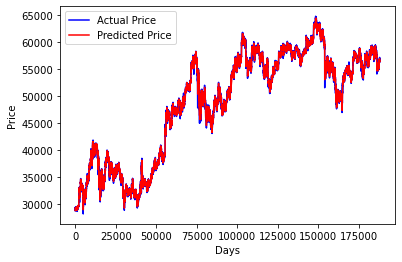

In [95]:
# plot true/pred prices graph
plot_graph(final_df)

In [96]:
final_df.head(5)

,date,low,high,open,close,volume,close_5,true_close_5,buy_profit,sell_profit,buy_profit_percent,sell_profit_percent
19.0,1609460340,28820.72,28852.48,28823.21,28820.72,35.359406,28904.908203,28846.46,25.74,0.0,0.000893,0.0
20.0,1609460400,28751.58,28822.17,28822.17,28759.35,35.799104,28902.384766,28871.28,111.93,0.0,0.003892,0.0
21.0,1609460460,28744.09,28796.23,28757.97,28796.23,44.561433,28896.773438,28844.48,48.25,0.0,0.001676,0.0
22.0,1609460520,28780.11,28802.19,28796.23,28796.29,18.573683,28890.763672,28839.57,43.28,0.0,0.001503,0.0
23.0,1609460580,28796.56,28835.44,28796.56,28835.01,38.595434,28886.990234,28833.96,-1.05,0.0,-0.000036,0.0


In [97]:
final_df.tail(5)

,date,low,high,open,close,volume,close_5,true_close_5,buy_profit,sell_profit,buy_profit_percent,sell_profit_percent
188061.0,1620778800,56913.09,56956.53,56810.00,56827.84,39.763972,56839.656250,56936.72,108.88,0.00,0.001916,0.000000
188062.0,1620778860,56826.38,56913.31,56825.68,56902.75,43.891996,56867.347656,56985.32,0.00,-82.57,0.000000,-0.001451
188063.0,1620778920,56902.76,56940.61,56892.12,56917.76,31.132963,56897.425781,56995.56,0.00,-77.80,0.000000,-0.001367
188064.0,1620778980,56917.76,56925.35,56874.82,56882.45,30.368818,56917.828125,56980.00,97.55,0.00,0.001715,0.000000
188065.0,1620779040,56882.44,56896.72,56857.62,56877.59,42.077266,56928.597656,56985.68,108.09,0.00,0.001900,0.000000


In [98]:
money = 100
max_money = 100
min_money = 100

for i in final_df.buy_profit_percent:
    money = money * (1 + i)
    if money > max_money:
        max_money = money
    elif money < min_money:
        min_money = money
print(f"BUYING End Money: {money:.2f}     Max Money: {max_money:0.2f}     Min Money: {min_money:0.2f}")

money = 100
max_money = 100
min_money = 100

for i in final_df.sell_profit_percent:
    money = money * (1 + i)
    if money > max_money:
        max_money = money
    elif money < min_money:
        min_money = money
print(f"SHORTING End Money: {money:.2f}     Max Money: {max_money:0.2f}     Min Money: {min_money:0.2f}")

BUYING End Money: 25297.72     Max Money: 25297.72     Min Money: 73.55
SHORTING End Money: 338.08     Max Money: 351.85     Min Money: 11.13


In [99]:
final_df['predicted_diff'] = (final_df[f"close_{LOOKUP_STEP}"] - final_df['close']) / final_df['close']
final_df

,date,low,high,open,close,volume,close_5,true_close_5,buy_profit,sell_profit,buy_profit_percent,sell_profit_percent,predicted_diff
19.0,1609460340,28820.72,28852.48,28823.21,28820.72,35.359406,28904.908203,28846.46,25.74,0.00,0.000893,0.000000,0.002921
20.0,1609460400,28751.58,28822.17,28822.17,28759.35,35.799104,28902.384766,28871.28,111.93,0.00,0.003892,0.000000,0.004974
21.0,1609460460,28744.09,28796.23,28757.97,28796.23,44.561433,28896.773438,28844.48,48.25,0.00,0.001676,0.000000,0.003492
22.0,1609460520,28780.11,28802.19,28796.23,28796.29,18.573683,28890.763672,28839.57,43.28,0.00,0.001503,0.000000,0.003281
23.0,1609460580,28796.56,28835.44,28796.56,28835.01,38.595434,28886.990234,28833.96,-1.05,0.00,-0.000036,0.000000,0.001803
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188061.0,1620778800,56913.09,56956.53,56810.00,56827.84,39.763972,56839.656250,56936.72,108.88,0.00,0.001916,0.000000,0.000208
188062.0,1620778860,56826.38,56913.31,56825.68,56902.75,43.891996,56867.347656,56985.32,0.00,-82.57,0.000000,-0.001451,-0.000622
188063.0,1620778920,56902.76,56940.61,56892.12,56917.76,31.132963,56897.425781,56995.56,0.00,-77.80,0.000000,-0.001367,-0.000357
188064.0,1620778980,56917.76,56925.35,56874.82,56882.45,30.368818,56917.828125,56980.00,97.55,0.00,0.001715,0.000000,0.000622


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002E24445A5E0>]],
      dtype=object)

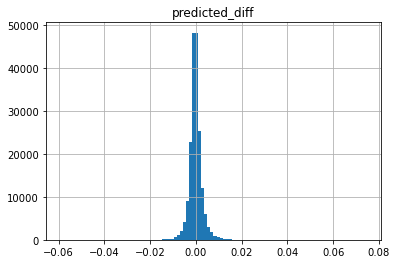

In [100]:
final_df.hist('predicted_diff', bins=100)

In [101]:
pos = final_df['predicted_diff'].where(final_df['predicted_diff'] > 0).count()
neg = final_df['predicted_diff'].where(final_df['predicted_diff'] < 0).count()
tot = final_df['predicted_diff'].count()

print(f"Number positive:  {pos}")
print(f"Number negative:  {neg}")

Number positive:  85949
Number negative:  102080


In [102]:
vals = [0, 0.001, 0.002, 0.01, 0.03]
tot = final_df['predicted_diff'].count()

for i in vals:
    pos = final_df['predicted_diff'].where(final_df['predicted_diff'] > i).count()
    neg = final_df['predicted_diff'].where(final_df['predicted_diff'] < -i).count()

    print(f'For value of {i}')
    print(f'Num pos: {pos}     Num neg: {neg}')
    print(f'Percent positive: {100*pos/tot}')
    print(f'Percent negative: {100*neg/tot}')
    print()

For value of 0
Num pos: 85949     Num neg: 102080
Percent positive: 45.710502103398944
Percent negative: 54.289497896601056

For value of 0.001
Num pos: 51595     Num neg: 61232
Percent positive: 27.43991618314196
Percent negative: 32.56518941227151

For value of 0.002
Num pos: 30692     Num neg: 32292
Percent positive: 16.323014003159088
Percent negative: 17.17394657207133

For value of 0.01
Num pos: 1351     Num neg: 808
Percent positive: 0.7185061878752745
Percent negative: 0.42972094730068233

For value of 0.03
Num pos: 27     Num neg: 22
Percent positive: 0.014359487100394088
Percent negative: 0.011700322822543331



In [103]:
final_df['predicted_diff'].describe()

count    188029.000000
mean         -0.000043
std           0.002982
min          -0.058871
25%          -0.001420
50%          -0.000189
75%           0.001179
max           0.074208
Name: predicted_diff, dtype: float64

In [104]:
final_df['buy_profit'].where(final_df['predicted_diff'] > 0).describe()

count    85949.000000
mean         3.290812
std        158.931108
min      -4330.030000
25%        -67.270000
50%          6.540000
75%         79.560000
max       2742.880000
Name: buy_profit, dtype: float64

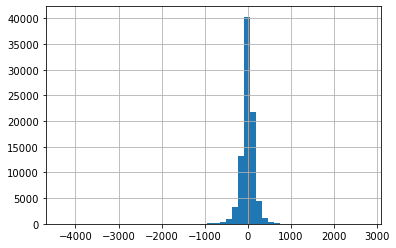

In [105]:
final_df['buy_profit'].where(final_df['predicted_diff'] > 0).hist(bins = 50)

count    102080.000000
mean          1.384833
std         135.856659
min       -1827.710000
25%         -64.510000
50%           6.030000
75%          71.782500
max        1907.110000
Name: sell_profit, dtype: float64


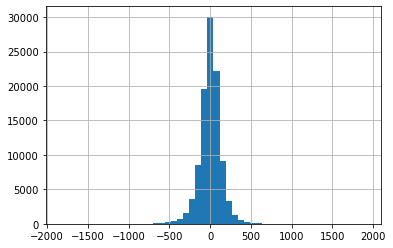

In [106]:
print(final_df['sell_profit'].where(final_df['predicted_diff'] < 0).describe())

final_df['sell_profit'].where(final_df['predicted_diff'] < 0).hist(bins = 50)

In [74]:
#final_df.running_buy_total = final_df.running_buy_total.shift(-1) * (1 + final_df.buy_profit_percent)

In [107]:
money = 100
max_money = 100
min_money = 100

for i, row in final_df.iterrows():
    money = money * (1 + row.buy_profit_percent)
    final_df.at[i, 'running_buy_total'] = money
    if money > max_money:
        max_money = money
    elif money < min_money:
        min_money = money
print(f"BUYING End Money: {money:.2f}     Max Money: {max_money:0.2f}     Min Money: {min_money:0.2f}")

money = 100
max_money = 100
min_money = 100

for i, row in final_df.iterrows():
    money = money * (1 + row.sell_profit_percent)
    final_df.at[i, 'running_sell_total'] = money
    if money > max_money:
        max_money = money
    elif money < min_money:
        min_money = money
print(f"SELLING End Money: {money:.2f}     Max Money: {max_money:0.2f}     Min Money: {min_money:0.2f}")


BUYING End Money: 25297.72     Max Money: 25297.72     Min Money: 73.55
SELLING End Money: 338.08     Max Money: 351.85     Min Money: 11.13


In [108]:
final_df.tail()

,date,low,high,open,close,volume,close_5,true_close_5,buy_profit,sell_profit,buy_profit_percent,sell_profit_percent,predicted_diff,running_buy_total,running_sell_total
188061.0,1620778800,56913.09,56956.53,56810.00,56827.84,39.763972,56839.656250,56936.72,108.88,0.00,0.001916,0.000000,0.000208,25206.511353,339.037076
188062.0,1620778860,56826.38,56913.31,56825.68,56902.75,43.891996,56867.347656,56985.32,0.00,-82.57,0.000000,-0.001451,-0.000622,25206.511353,338.545109
188063.0,1620778920,56902.76,56940.61,56892.12,56917.76,31.132963,56897.425781,56995.56,0.00,-77.80,0.000000,-0.001367,-0.000357,25206.511353,338.082357
188064.0,1620778980,56917.76,56925.35,56874.82,56882.45,30.368818,56917.828125,56980.00,97.55,0.00,0.001715,0.000000,0.000622,25249.739013,338.082357
188065.0,1620779040,56882.44,56896.72,56857.62,56877.59,42.077266,56928.597656,56985.68,108.09,0.00,0.001900,0.000000,0.000897,25297.723540,338.082357


In [109]:
final_df.head(10)

,date,low,high,open,close,volume,close_5,true_close_5,buy_profit,sell_profit,buy_profit_percent,sell_profit_percent,predicted_diff,running_buy_total,running_sell_total
19.0,1609460340,28820.72,28852.48,28823.21,28820.72,35.359406,28904.908203,28846.46,25.74,0.0,0.000893,0.0,0.002921,100.089311,100.0
20.0,1609460400,28751.58,28822.17,28822.17,28759.35,35.799104,28902.384766,28871.28,111.93,0.0,0.003892,0.0,0.004974,100.478854,100.0
21.0,1609460460,28744.09,28796.23,28757.97,28796.23,44.561433,28896.773438,28844.48,48.25,0.0,0.001676,0.0,0.003492,100.647213,100.0
22.0,1609460520,28780.11,28802.19,28796.23,28796.29,18.573683,28890.763672,28839.57,43.28,0.0,0.001503,0.0,0.003281,100.798482,100.0
23.0,1609460580,28796.56,28835.44,28796.56,28835.01,38.595434,28886.990234,28833.96,-1.05,0.0,-0.000036,0.0,0.001803,100.794812,100.0
24.0,1609460640,28822.03,28846.46,28835.01,28846.46,23.787130,28882.470703,28836.63,-9.83,0.0,-0.000341,0.0,0.001248,100.760464,100.0
25.0,1609460700,28841.66,28871.28,28844.88,28871.28,37.069495,28880.789062,28875.75,4.47,0.0,0.000155,0.0,0.000329,100.776064,100.0
26.0,1609460760,28822.01,28875.55,28871.28,28844.48,50.016234,28872.095703,28858.53,14.05,0.0,0.000487,0.0,0.000957,100.825152,100.0
27.0,1609460820,28823.49,28844.48,28844.48,28839.57,31.830089,28860.576172,28871.97,32.40,0.0,0.001123,0.0,0.000728,100.938425,100.0
28.0,1609460880,28828.92,28844.10,28839.58,28833.96,10.930214,28849.529297,28890.00,56.04,0.0,0.001944,0.0,0.000540,101.134603,100.0


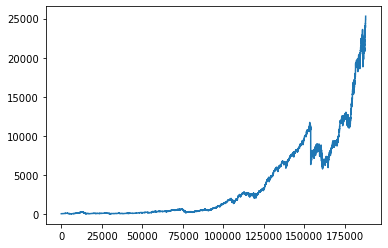

In [110]:
final_df.running_buy_total.plot()

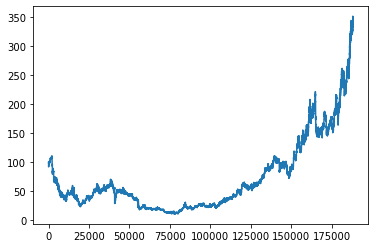

In [111]:
final_df.running_sell_total.plot()

In [ ]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
'''
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}
'''

In [81]:
def get_final_df_min_profit(model, data, hurdle=0):
    """
    This function takes the `model` and `data` dict to 
    construct a final dataframe that includes the features along 
    with true and predicted prices of the testing dataset
    If the change predicted is less than the 'hurdle' you will not do the trade.
    """
    # if predicted future price is higher than the current, 
    # then calculate the true future price minus the current price, to get the buy profit
    #buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    buy_profit  = lambda current, pred_future, true_future: true_future - current if (pred_future - current)/current > hurdle else 0

    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    #sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0
    sell_profit = lambda current, pred_future, true_future: current - true_future if (pred_future - current)/current < -hurdle else 0
    
    #buy_profit_percent  = lambda current, pred_future, true_future: (true_future - current) / current if pred_future > current else 0
    #sell_profit_percent = lambda current, pred_future, true_future: (current - true_future) / current if pred_future < current else 0
    buy_profit_percent  = lambda current, pred_future, true_future: (true_future - current) / current if (pred_future - current)/current > hurdle else 0
    sell_profit_percent = lambda current, pred_future, true_future: (current - true_future) / current if (pred_future - current)/current < -hurdle else 0
    
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["close"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["close"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"close_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_close_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["close"], 
                                    final_df[f"close_{LOOKUP_STEP}"], 
                                    final_df[f"true_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["close"], 
                                    final_df[f"close_{LOOKUP_STEP}"], 
                                    final_df[f"true_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the buy profit column
    final_df["buy_profit_percent"] = list(map(buy_profit_percent, 
                                    final_df["close"], 
                                    final_df[f"close_{LOOKUP_STEP}"], 
                                    final_df[f"true_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit_percent"] = list(map(sell_profit_percent, 
                                    final_df["close"], 
                                    final_df[f"close_{LOOKUP_STEP}"], 
                                    final_df[f"true_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    
    final_df['predicted_diff'] = (final_df[f"close_{LOOKUP_STEP}"] - final_df['close']) / final_df['close']

    money = 100
    max_money = 100
    min_money = 100

    for i, row in final_df.iterrows():
        money = money * (1 + row.buy_profit_percent)
        final_df.at[i, 'running_buy_total'] = money
        if money > max_money:
            max_money = money
        elif money < min_money:
            min_money = money
    print(f"BUYING End Money: {money:.2f}     Max Money: {max_money:0.2f}     Min Money: {min_money:0.2f}")

    money = 100
    max_money = 100
    min_money = 100

    for i, row in final_df.iterrows():
        money = money * (1 + row.sell_profit_percent)
        final_df.at[i, 'running_sell_total'] = money
        if money > max_money:
            max_money = money
        elif money < min_money:
            min_money = money
    print(f"SELLING End Money: {money:.2f}     Max Money: {max_money:0.2f}     Min Money: {min_money:0.2f}")

    return final_df

In [156]:
def Test_On_File(file_name, hurdle=0):
    TEST_SIZE = 0.9999

    # set seed, so we can get the same results after rerunning several times
    np.random.seed(315)
    tf.random.set_seed(315)
    random.seed(315)

    # create these folders if they does not exist
    if not os.path.isdir("results"):
        os.mkdir("results")

    if not os.path.isdir("logs"):
        os.mkdir("logs")

    if not os.path.isdir("data"):
        os.mkdir("data")
    print("One")
    # load the data
    data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                    shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                    feature_columns=FEATURE_COLUMNS, multiyear=False, file_name=MY_PATH + 'archive/' + file_name)
    print("Two")
    # save the dataframe
    data["df"].to_csv(ticker_data_filename)
    print("Three")
    '''
    # construct the model
    model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                        dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

    print("--------------------")
    print(model.summary())
    print("--------------------")
    print()
    '''
    # load optimal model weights from results folder
    model_path = os.path.join(MY_PATH + "results", model_name) + ".h5"

    # put custom path for model weights here
    #model_path = "results/2021-06-06_BTC-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-20-step-5-layers-2-units-256-epochs-5-batchsize-128-dropout-30-b.h5"

    model.load_weights(model_path)

    # evaluate the model
    loss, mae, mse = model.evaluate(data["X_test"], data["y_test"], verbose=0)
    # calculate the mean absolute error (inverse scaling)
    if SCALE:
        mean_absolute_error = data["column_scaler"]["close"].inverse_transform([[mae]])[0][0]
        mean_standard_error = data["column_scaler"]["close"].inverse_transform([[mse]])[0][0]
    else:
        mean_absolute_error = mae
        mean_standard_error = mse

    # get the final dataframe for the testing set
    final_df = get_final_df_min_profit(model, data, hurdle)

    # predict the future price
    future_price = predict(model, data)

    # we calculate the accuracy by counting the number of positive profits
    accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
    percent_buys = (len(final_df[final_df['buy_profit'] > 0]) + len(final_df[final_df['buy_profit'] < 0])) / len(final_df)
    percent_sells = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['sell_profit'] < 0])) / len(final_df)
    # calculating total buy & sell profit
    total_buy_profit  = final_df["buy_profit"].sum()
    total_sell_profit = final_df["sell_profit"].sum()
    total_buy_profit_percent  = final_df["buy_profit_percent"].sum()
    total_sell_profit_percent = final_df["sell_profit_percent"].sum()
    # total profit by adding sell & buy together
    total_profit = total_buy_profit + total_sell_profit
    total_profit_percent = total_buy_profit_percent + total_sell_profit_percent
    # dividing total profit by number of testing samples (number of trades)
    profit_per_trade = total_profit / len(final_df)
    profit_per_trade_percent = total_profit_percent / len(final_df)
    num_trades = len(final_df)
    percent_profitable_buys = len(final_df[final_df['buy_profit'] > 0]) / (len(final_df[final_df['buy_profit'] > 0]) + len(final_df[final_df['buy_profit'] < 0]))
    percent_profitable_sell = len(final_df[final_df['sell_profit'] > 0]) / (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['sell_profit'] < 0]))
    
    
    # printing metrics
    print(f"Future price after {LOOKUP_STEP} time periods is ${future_price}")
    print(f"{LOSS} loss: {loss}")
    #print(f"Mean Absolute Error:", mean_absolute_error)
    print(f"Mean Squared Error: {mean_standard_error:.4f}")
    print(f"Accuracy score: {accuracy_score:.4f}")
    print(f"Percent of buys: {percent_buys:.4f}")
    print(f"Percent of sells: {percent_sells:.4f}")
    print(f"Total buy profit: {total_buy_profit:.4f}")
    print(f"Total sell profit: {total_sell_profit:.4f}")
    print(f"Percent profitable buys: {percent_profitable_buys:.4f}")
    print(f"Percent profitable sells: {percent_profitable_sells:.4f}")
    print(f"Total buy profit %: {total_buy_profit_percent:.4f}")
    print(f"Total sell profit %: {total_sell_profit_percent:.4f}")
    print(f"Total profit: {total_profit:.4f}")
    print(f"Total profit %: {total_profit_percent:.4f}")
    print(f"Profit per trade: {profit_per_trade:.9f}")
    print(f"Profit per trade %: {profit_per_trade_percent:.9f}")
    print(f"Possible Number of trades: {num_trades}")
    print(f"Number of trades: {(percent_buys + percent_sells) * num_trades}")
    print(f"Steps: {N_STEPS}  Lookup Steps: {LOOKUP_STEP}   Testsize: {TEST_SIZE}   Layers: {N_LAYERS}")
    print(f"Epochs: {EPOCHS}   Batchsize: {BATCH_SIZE}  Bidirectional: {BIDIRECTIONAL}")
    print(f"Filename: {file_name}")
    print(f"Model Name: {model_name}")
    print()

    '''
    money = 100
    max_money = 100
    min_money = 100
    buy_count = 0
    stand_count = 0

    for i in final_df.buy_profit_percent:
        if i != 0:
            buy_count += 1
            stand_count -= 1
        else:
            stand_count += 1
        money = money * (1 + i)
        if money > max_money:
            max_money = money
        elif money < min_money:
            min_money = money

    print(f"BUYING End Money: {money:.2f}     Max Money: {max_money:0.2f}     Min Money: {min_money:0.2f}")

    money = 100
    max_money = 100
    min_money = 100
    sell_count = 0

    for i in final_df.sell_profit_percent:
        if i != 0:
            sell_count += 1
            stand_count -= 1
        else:
            stand_count += 1
        money = money * (1 + i)
        if money > max_money:
            max_money = money
        elif money < min_money:
            min_money = money
    print(f"SHORTING End Money: {money:.2f}     Max Money: {max_money:0.2f}     Min Money: {min_money:0.2f}")

    print(f"{buy_count} Buys     {sell_count} Sells     {stand_count} Passes")
    '''
    # plot true/pred prices graph
    plot_graph(final_df)

    #print(final_df.hist('predicted_diff', bins=100))
    final_df.running_buy_total.plot()
    #print(final_df.running_sell_total.plot())
    
    return final_df

One
              date       low      high      open     close     volume
0       1609459200  28913.12  28961.66  28923.63  28961.66  27.457032
1       1609459260  28961.01  29017.50  28961.67  29009.91  58.477501
2       1609459320  28973.58  29016.71  29009.54  28989.30  42.470329
3       1609459380  28972.33  28999.85  28989.68  28982.69  30.360677
4       1609459440  28971.80  28995.93  28982.67  28975.65  24.124339
...            ...       ...       ...       ...       ...        ...
188066  1620779100  56877.58  56952.58  56836.73  56936.72  34.775288
188067  1620779160  56936.73  57005.57  56936.72  56985.32  36.081370
188068  1620779220  56985.33  57009.97  56950.00  56995.56  43.744229
188069  1620779280  56995.56  57007.94  56966.09  56980.00  38.086665
188070  1620779340  56980.00  56998.00  56930.45  56985.68  33.428374

[188071 rows x 6 columns]
Two
Three
BUYING End Money: 2498.50     Max Money: 2617.44     Min Money: 76.69
SELLING End Money: 44.30     Max Money: 103.79   

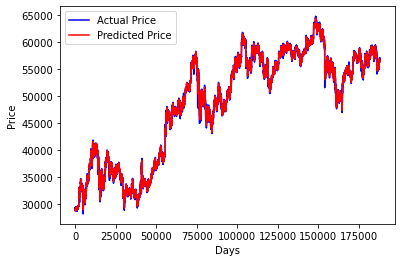

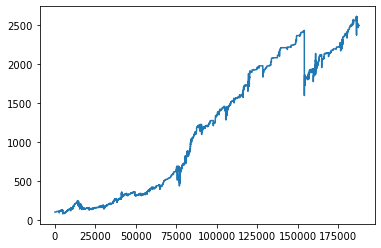

In [83]:
a4 = Test_On_File('BTCUSDT_2021.csv', hurdle=0.004)

One
              date       low      high      open     close     volume
0       1609459200  28913.12  28961.66  28923.63  28961.66  27.457032
1       1609459260  28961.01  29017.50  28961.67  29009.91  58.477501
2       1609459320  28973.58  29016.71  29009.54  28989.30  42.470329
3       1609459380  28972.33  28999.85  28989.68  28982.69  30.360677
4       1609459440  28971.80  28995.93  28982.67  28975.65  24.124339
...            ...       ...       ...       ...       ...        ...
188066  1620779100  56877.58  56952.58  56836.73  56936.72  34.775288
188067  1620779160  56936.73  57005.57  56936.72  56985.32  36.081370
188068  1620779220  56985.33  57009.97  56950.00  56995.56  43.744229
188069  1620779280  56995.56  57007.94  56966.09  56980.00  38.086665
188070  1620779340  56980.00  56998.00  56930.45  56985.68  33.428374

[188071 rows x 6 columns]
Two
Three
BUYING End Money: 18380.12     Max Money: 19367.66     Min Money: 76.17
SELLING End Money: 165.32     Max Money: 166.21

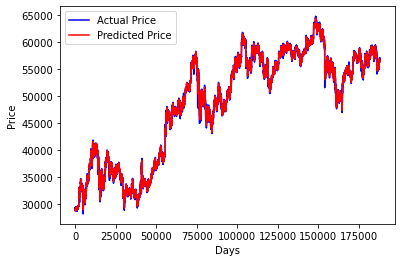

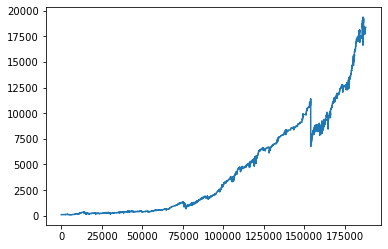

In [84]:
a2 = Test_On_File('BTCUSDT_2021.csv', hurdle=0.002)

One
              date       low      high      open     close     volume
0       1609459200  28913.12  28961.66  28923.63  28961.66  27.457032
1       1609459260  28961.01  29017.50  28961.67  29009.91  58.477501
2       1609459320  28973.58  29016.71  29009.54  28989.30  42.470329
3       1609459380  28972.33  28999.85  28989.68  28982.69  30.360677
4       1609459440  28971.80  28995.93  28982.67  28975.65  24.124339
...            ...       ...       ...       ...       ...        ...
188066  1620779100  56877.58  56952.58  56836.73  56936.72  34.775288
188067  1620779160  56936.73  57005.57  56936.72  56985.32  36.081370
188068  1620779220  56985.33  57009.97  56950.00  56995.56  43.744229
188069  1620779280  56995.56  57007.94  56966.09  56980.00  38.086665
188070  1620779340  56980.00  56998.00  56930.45  56985.68  33.428374

[188071 rows x 6 columns]
Two
Three
BUYING End Money: 80462.46     Max Money: 80462.46     Min Money: 75.11
SELLING End Money: 171.86     Max Money: 176.90

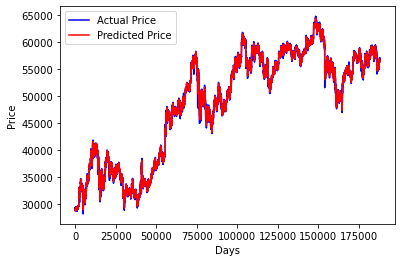

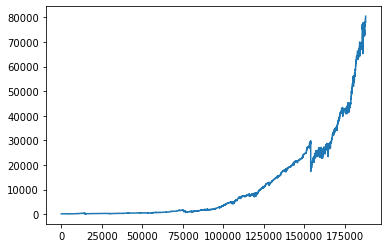

In [85]:
a1 = Test_On_File('BTCUSDT_2021.csv', hurdle=0.001)

One
              date       low      high      open     close     volume
0       1609459200  28913.12  28961.66  28923.63  28961.66  27.457032
1       1609459260  28961.01  29017.50  28961.67  29009.91  58.477501
2       1609459320  28973.58  29016.71  29009.54  28989.30  42.470329
3       1609459380  28972.33  28999.85  28989.68  28982.69  30.360677
4       1609459440  28971.80  28995.93  28982.67  28975.65  24.124339
...            ...       ...       ...       ...       ...        ...
188066  1620779100  56877.58  56952.58  56836.73  56936.72  34.775288
188067  1620779160  56936.73  57005.57  56936.72  56985.32  36.081370
188068  1620779220  56985.33  57009.97  56950.00  56995.56  43.744229
188069  1620779280  56995.56  57007.94  56966.09  56980.00  38.086665
188070  1620779340  56980.00  56998.00  56930.45  56985.68  33.428374

[188071 rows x 6 columns]
Two
Three
BUYING End Money: 25152.35     Max Money: 25152.35     Min Money: 73.55
SELLING End Money: 345.93     Max Money: 360.02

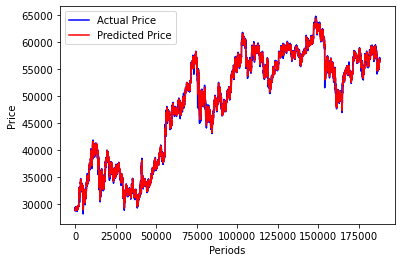

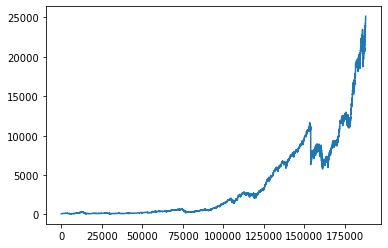

In [158]:
a0 = Test_On_File('BTCUSDT_2021.csv', hurdle=0)

One
                unix           date   symbol         open         high  \
0       1.609460e+12  1/1/2021 0:00  BTC/USD  28939.00000  28968.00000   
1       1.609460e+12  1/1/2021 0:01  BTC/USD  28967.00000  29033.00000   
2       1.609460e+12  1/1/2021 0:02  BTC/USD  29020.00000  29021.00000   
3       1.609460e+12  1/1/2021 0:03  BTC/USD  28992.27007  29000.00000   
4       1.609460e+12  1/1/2021 0:04  BTC/USD  28988.00000  28993.00000   
...              ...            ...      ...          ...          ...   
305454  1.628140e+12  8/5/2021 6:08  BTC/USD  39319.00000  39363.00000   
305455  1.628140e+12  8/5/2021 6:09  BTC/USD  39360.57135  39361.00000   
305456  1.628140e+12  8/5/2021 6:10  BTC/USD  39356.40297  39356.40297   
305457  1.628140e+12  8/5/2021 6:11  BTC/USD  39325.00000  39325.00000   
305458  1.628140e+12  8/5/2021 6:12  BTC/USD  39317.00000  39317.00000   

                low        close     Volume USD  Volume BTC  
0       28927.00000  28965.00000  236654.8797

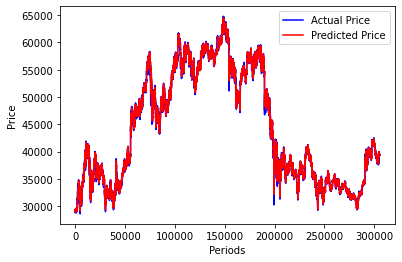

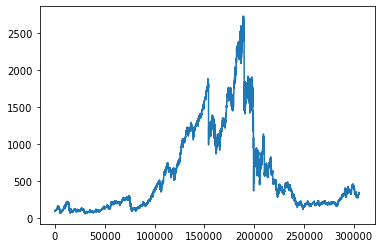

In [159]:
b0 = Test_On_File('Bitfinex_BTCUSD_minute2021.csv', hurdle=0)

One
                unix           date   symbol         open         high  \
0       1.609460e+12  1/1/2021 0:00  BTC/USD  28939.00000  28968.00000   
1       1.609460e+12  1/1/2021 0:01  BTC/USD  28967.00000  29033.00000   
2       1.609460e+12  1/1/2021 0:02  BTC/USD  29020.00000  29021.00000   
3       1.609460e+12  1/1/2021 0:03  BTC/USD  28992.27007  29000.00000   
4       1.609460e+12  1/1/2021 0:04  BTC/USD  28988.00000  28993.00000   
...              ...            ...      ...          ...          ...   
305454  1.628140e+12  8/5/2021 6:08  BTC/USD  39319.00000  39363.00000   
305455  1.628140e+12  8/5/2021 6:09  BTC/USD  39360.57135  39361.00000   
305456  1.628140e+12  8/5/2021 6:10  BTC/USD  39356.40297  39356.40297   
305457  1.628140e+12  8/5/2021 6:11  BTC/USD  39325.00000  39325.00000   
305458  1.628140e+12  8/5/2021 6:12  BTC/USD  39317.00000  39317.00000   

                low        close     Volume USD  Volume BTC  
0       28927.00000  28965.00000  236654.8797

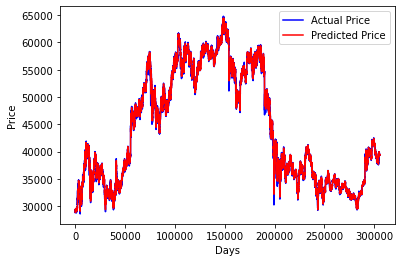

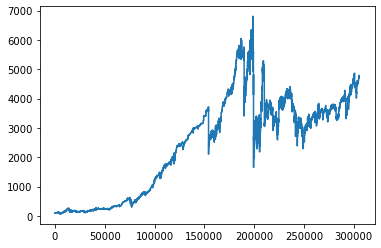

In [88]:
b2 = Test_On_File('Bitfinex_BTCUSD_minute2021.csv', hurdle=0.002)

One
              date     low    high    open   close    volume
0       1502942400  301.13  301.13  301.13  301.13   0.42643
1       1502942460  301.13  301.13  301.13  301.13   2.75787
2       1502942520  300.00  300.00  300.00  300.00   0.09930
3       1502942580  300.00  300.00  300.00  300.00   0.31389
4       1502942640  301.13  301.13  301.13  301.13   0.23202
...            ...     ...     ...     ...     ...       ...
196540  1514764500  732.50  733.79  732.50  732.52   7.61926
196541  1514764560  732.99  734.01  732.53  734.01  58.11788
196542  1514764620  734.01  734.97  733.10  734.01  19.83970
196543  1514764680  734.01  734.01  732.56  733.99   9.52489
196544  1514764740  733.99  734.00  733.98  733.98  12.76931

[196545 rows x 6 columns]
Two
Three
BUYING End Money: 922606794407637851768046485504.00     Max Money: 24947804852332135229932099862528.00     Min Money: 99.75
SELLING End Money: 873005720145968560225648640.00     Max Money: 380668754192583728525333233664.00     

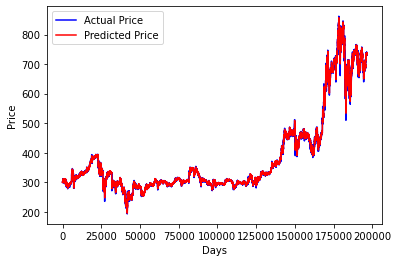

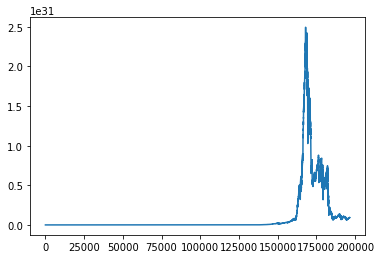

In [89]:
e17 = Test_On_File('ETHUSDT_2017.csv', hurdle=0.000)

In [128]:
e17

,date,low,high,open,close,volume,close_5,true_close_5,buy_profit,sell_profit,buy_profit_percent,sell_profit_percent,predicted_diff,running_buy_total,running_sell_total
19.0,1502943540,299.05,299.05,299.05,299.05,0.37758,299.791138,300.10,1.05,0.00,0.003511,0.000000,0.002478,1.003511e+02,1.000000e+02
20.0,1502943600,299.05,299.05,299.05,299.05,0.17585,299.858429,299.40,0.35,0.00,0.001170,0.000000,0.002703,1.004686e+02,1.000000e+02
21.0,1502943660,299.05,300.10,299.05,300.10,6.40719,300.000885,300.80,0.00,-0.70,0.000000,-0.002333,-0.000330,1.004686e+02,9.976674e+01
22.0,1502943720,300.10,300.10,300.10,300.10,0.00000,300.175385,299.39,-0.71,0.00,-0.002366,0.000000,0.000251,1.002309e+02,9.976674e+01
23.0,1502943780,300.10,300.10,300.10,300.10,0.00000,300.249878,299.39,-0.71,0.00,-0.002366,0.000000,0.000499,9.999373e+01,9.976674e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196535.0,1514764200,736.22,736.73,735.13,736.00,6.96775,734.021851,732.52,0.00,3.48,0.000000,0.004728,-0.002688,9.207716e+29,8.692045e+26
196536.0,1514764260,736.00,736.71,735.07,735.07,74.28985,734.197937,734.01,0.00,1.06,0.000000,0.001442,-0.001186,9.207716e+29,8.704579e+26
196537.0,1514764320,735.07,735.68,735.07,735.08,25.28816,734.159119,734.01,0.00,1.07,0.000000,0.001456,-0.001253,9.207716e+29,8.717249e+26
196538.0,1514764380,735.08,735.51,735.02,735.07,71.26878,734.163147,733.99,0.00,1.08,0.000000,0.001469,-0.001234,9.207716e+29,8.730057e+26


One
              date      low     high     open    close      volume
0       1609459200   735.94   737.09   736.42   737.02   647.71994
1       1609459260   737.06   739.00   737.12   738.74  1122.95415
2       1609459320   737.35   738.81   738.78   737.82   418.49987
3       1609459380   737.28   738.20   737.74   737.43   305.98424
4       1609459440   736.80   737.80   737.38   736.89   350.36312
...            ...      ...      ...      ...      ...         ...
196867  1621307160  3390.82  3390.82  3387.66  3388.46   368.31582
196868  1621307220  3388.89  3398.75  3388.89  3393.71   640.40309
196869  1621307280  3393.73  3393.73  3385.38  3389.95   502.90712
196870  1621307340  3390.00  3396.12  3384.12  3386.18   907.30921
196871  1621307400  3386.19  3388.33  3384.66  3388.32    58.64433

[196872 rows x 6 columns]
Two
Three
BUYING End Money: 64087.79     Max Money: 103341.41     Min Money: 93.03
SELLING End Money: 9.69     Max Money: 103.01     Min Money: 3.82
shape:     (20, 

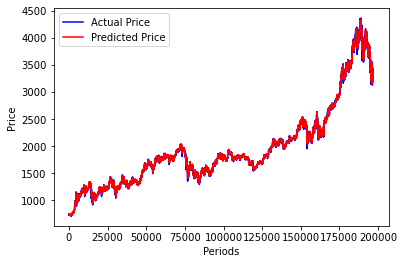

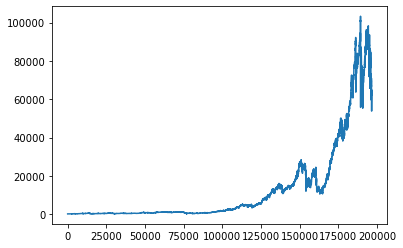

In [157]:
e210 = Test_On_File('ETHUSDT_2021.csv', hurdle=0.000)

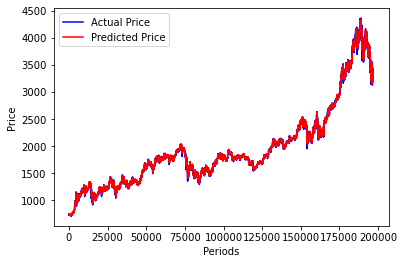

In [155]:
plot_graph(e210)


One
              date      low     high     open    close      volume
0       1609459200   735.94   737.09   736.42   737.02   647.71994
1       1609459260   737.06   739.00   737.12   738.74  1122.95415
2       1609459320   737.35   738.81   738.78   737.82   418.49987
3       1609459380   737.28   738.20   737.74   737.43   305.98424
4       1609459440   736.80   737.80   737.38   736.89   350.36312
...            ...      ...      ...      ...      ...         ...
196867  1621307160  3390.82  3390.82  3387.66  3388.46   368.31582
196868  1621307220  3388.89  3398.75  3388.89  3393.71   640.40309
196869  1621307280  3393.73  3393.73  3385.38  3389.95   502.90712
196870  1621307340  3390.00  3396.12  3384.12  3386.18   907.30921
196871  1621307400  3386.19  3388.33  3384.66  3388.32    58.64433

[196872 rows x 6 columns]
Two
Three
BUYING End Money: 108885.28     Max Money: 130970.34     Min Money: 96.41
SELLING End Money: 21.87     Max Money: 101.06     Min Money: 10.94
shape:     (2

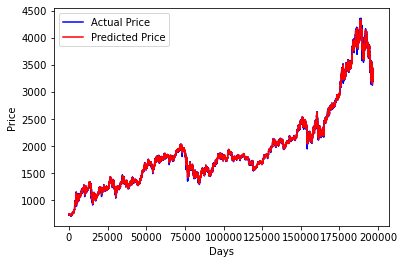

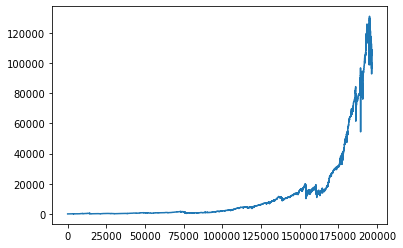

In [113]:
e212 = Test_On_File('ETHUSDT_2021.csv', hurdle=0.002)

One
              date       low      high      open     close  volume
0       1609459200  0.004295  0.004298  0.004295  0.004298  185.59
1       1609459260  0.004298  0.004305  0.004299  0.004302  263.31
2       1609459320  0.004298  0.004304  0.004304  0.004300   72.61
3       1609459380  0.004297  0.004300  0.004299  0.004298   35.22
4       1609459440  0.004296  0.004301  0.004298  0.004297  136.97
...            ...       ...       ...       ...       ...     ...
196908  1621309620  0.006783  0.006786  0.006775  0.006775  213.87
196909  1621309680  0.006775  0.006781  0.006775  0.006781   44.40
196910  1621309740  0.006782  0.006785  0.006775  0.006785  122.64
196911  1621309800  0.006785  0.006785  0.006767  0.006767  274.14
196912  1621309860  0.006767  0.006773  0.006766  0.006770   28.70

[196913 rows x 6 columns]
Two
Three
BUYING End Money: 30046.26     Max Money: 30046.26     Min Money: 80.41
SELLING End Money: 1204.12     Max Money: 3983.75     Min Money: 41.17
shape:     (

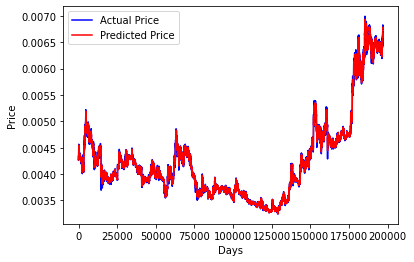

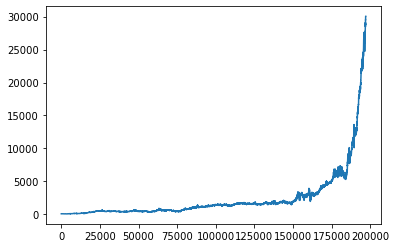

In [114]:
L210 = Test_On_File('LTCBTC_2021.csv', hurdle=0.000)

One
              date       low      high      open     close  volume
0       1609459200  0.004295  0.004298  0.004295  0.004298  185.59
1       1609459260  0.004298  0.004305  0.004299  0.004302  263.31
2       1609459320  0.004298  0.004304  0.004304  0.004300   72.61
3       1609459380  0.004297  0.004300  0.004299  0.004298   35.22
4       1609459440  0.004296  0.004301  0.004298  0.004297  136.97
...            ...       ...       ...       ...       ...     ...
196908  1621309620  0.006783  0.006786  0.006775  0.006775  213.87
196909  1621309680  0.006775  0.006781  0.006775  0.006781   44.40
196910  1621309740  0.006782  0.006785  0.006775  0.006785  122.64
196911  1621309800  0.006785  0.006785  0.006767  0.006767  274.14
196912  1621309860  0.006767  0.006773  0.006766  0.006770   28.70

[196913 rows x 6 columns]
Two
Three
BUYING End Money: 164376.09     Max Money: 164376.09     Min Money: 93.14
SELLING End Money: 341.38     Max Money: 425.42     Min Money: 51.91
shape:     (

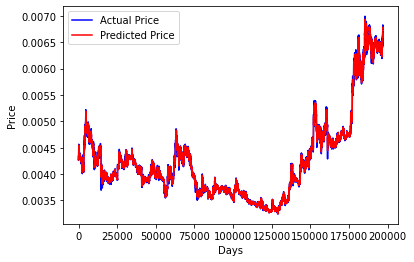

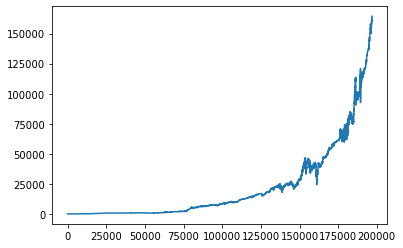

In [115]:
L212 = Test_On_File('LTCBTC_2021.csv', hurdle=0.002)

In [116]:
len(L212.where(L212.buy_profit_percent > 0))

196870

In [117]:
print(len(L212))
print(len(L212[L212['buy_profit_percent'] != 0]))
print(len(L212[L212['buy_profit_percent'] > 0]))
print(len(L212[L212['buy_profit_percent'] < 0]))
print(len(L212[L212['buy_profit_percent'] == 0]))
print()
print(L212[L212['buy_profit_percent'] > 0]['buy_profit_percent'].mean())
print(L212[L212['buy_profit_percent'] < 0]['buy_profit_percent'].mean())

196870
41438
21730
19708
155432

0.0026294777392147227
-0.0025063146886088587


In [118]:
L212[L212['buy_profit_percent'] < 0]

,date,low,high,open,close,volume,close_5,true_close_5,buy_profit,sell_profit,buy_profit_percent,sell_profit_percent,predicted_diff,running_buy_total,running_sell_total
19.0,1609460340,0.004283,0.004285,0.004283,0.004284,13.21,0.004294,0.004278,-0.000006,0.0,-0.001401,0.0,0.002425,99.859944,100.000000
20.0,1609460400,0.004283,0.004287,0.004285,0.004283,9.08,0.004293,0.004278,-0.000005,0.0,-0.001167,0.0,0.002416,99.743367,100.000000
21.0,1609460460,0.004275,0.004282,0.004282,0.004281,302.11,0.004292,0.004275,-0.000006,0.0,-0.001402,0.0,0.002530,99.603572,100.000000
22.0,1609460520,0.004280,0.004283,0.004282,0.004281,346.84,0.004291,0.004271,-0.000010,0.0,-0.002336,0.0,0.002241,99.370908,100.000000
24.0,1609460640,0.004275,0.004283,0.004283,0.004278,647.60,0.004289,0.004270,-0.000008,0.0,-0.001870,0.0,0.002522,99.185081,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196748.0,1621300020,0.006647,0.006649,0.006630,0.006632,114.56,0.006647,0.006589,-0.000043,0.0,-0.006484,0.0,0.002188,161131.781757,363.451741
196749.0,1621300080,0.006632,0.006635,0.006614,0.006615,164.43,0.006644,0.006592,-0.000023,0.0,-0.003477,0.0,0.004406,160571.535200,363.451741
196750.0,1621300140,0.006616,0.006628,0.006603,0.006610,460.58,0.006640,0.006601,-0.000009,0.0,-0.001362,0.0,0.004559,160352.905273,363.451741
196751.0,1621300200,0.006610,0.006613,0.006605,0.006610,459.08,0.006636,0.006586,-0.000024,0.0,-0.003631,0.0,0.004004,159770.685949,363.451741


In [119]:
len(L212[L212['buy_profit_percent'] != 0])

41438

In [120]:
len(L212[L212['buy_profit_percent'] == 0])

155432

In [121]:
L212[L212['buy_profit_percent'] != 0].mean()

date                   1.614995e+09
low                    4.235883e-03
high                   4.243718e-03
open                   4.237672e-03
close                  4.237081e-03
volume                 4.363473e+02
close_5                4.253098e-03
true_close_5           4.237854e-03
buy_profit             7.725518e-07
sell_profit            0.000000e+00
buy_profit_percent     1.868841e-04
sell_profit_percent    0.000000e+00
predicted_diff         3.741993e-03
running_buy_total      1.789569e+04
running_sell_total     1.853928e+02
dtype: float64

In [122]:
len(L212)

196870

One
              date       low      high      open     close  volume
0       1500005340  0.019000  0.019000  0.019000  0.019000   20.00
1       1500005400  0.019000  0.019000  0.019000  0.019000    0.00
2       1500005460  0.019000  0.019000  0.019000  0.019000    0.00
3       1500005520  0.019099  0.019099  0.019099  0.019099    1.59
4       1500005580  0.019099  0.019099  0.019099  0.019099    0.00
...            ...       ...       ...       ...       ...     ...
245493  1514764500  0.016340  0.016340  0.016311  0.016311  131.22
245494  1514764560  0.016338  0.016339  0.016311  0.016311  238.67
245495  1514764620  0.016318  0.016339  0.016311  0.016311  203.50
245496  1514764680  0.016311  0.016338  0.016311  0.016330  195.80
245497  1514764740  0.016313  0.016330  0.016311  0.016320  114.62

[245498 rows x 6 columns]
Two
Three
BUYING End Money: 4102430012290139422720.00     Max Money: 148388604186829711736832.00     Min Money: 62.85
SELLING End Money: 500767657542319472640.00    

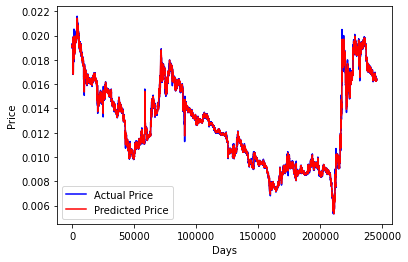

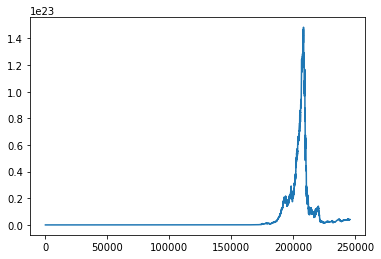

In [153]:
L17 = Test_On_File('LTCBTC_2017.csv', hurdle=0.000)

[[<matplotlib.axes._subplots.AxesSubplot object at 0x000002E234085040>]]
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


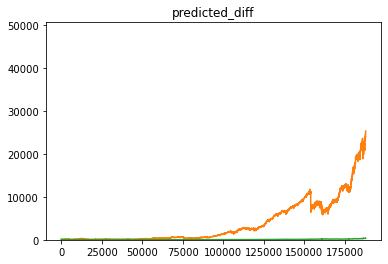

In [123]:
    print(final_df.hist('predicted_diff', bins=100))
    print(final_df.running_buy_total.plot())
    print(final_df.running_sell_total.plot())

In [124]:
money = 1
max_money = 1
min_money = 1
buy_count = 0
stand_count = 0

for i in L212.buy_profit_percent:
    if i != 0:
        buy_count += 1
        stand_count -= 1
    else:
        stand_count += 1
    money = money * (1 + i)
    if money > max_money:
        max_money = money
    elif money < min_money:
        min_money = money

print(f"BUYING End Money: {money:.2f}     Max Money: {max_money:0.2f}     Min Money: {min_money:0.2f}")

money = 1
max_money = 1
min_money = 1
sell_count = 0

for i in L212.sell_profit_percent:
    if i != 0:
        sell_count += 1
        stand_count -= 1
    else:
        stand_count += 1
    money = money * (1 + i)
    if money > max_money:
        max_money = money
    elif money < min_money:
        min_money = money
print(f"SHORTING End Money: {money:.2f}     Max Money: {max_money:0.2f}     Min Money: {min_money:0.2f}")

print(f"{buy_count} Buys     {sell_count} Sells     {stand_count} Passes")

BUYING End Money: 1643.76     Max Money: 1643.76     Min Money: 0.93
SHORTING End Money: 3.41     Max Money: 4.25     Min Money: 0.52
41438 Buys     26363 Sells     258138 Passes


In [125]:
money = 100
max_money = 100
min_money = 100
buy_count = 0
stand_count = 0

for i in L212.buy_profit_percent:
    if i != 0:
        buy_count += 1
        stand_count -= 1
    else:
        stand_count += 1
    money = money * (1 + i)
    if money > max_money:
        max_money = money
    elif money < min_money:
        min_money = money

print(f"BUYING End Money: {money:.2f}     Max Money: {max_money:0.2f}     Min Money: {min_money:0.2f}")

money = 100
max_money = 100
min_money = 100
sell_count = 0

for i in L212.sell_profit_percent:
    if i != 0:
        sell_count += 1
        stand_count -= 1
    else:
        stand_count += 1
    money = money * (1 + i)
    if money > max_money:
        max_money = money
    elif money < min_money:
        min_money = money
print(f"SHORTING End Money: {money:.2f}     Max Money: {max_money:0.2f}     Min Money: {min_money:0.2f}")

print(f"{buy_count} Buys     {sell_count} Sells     {stand_count} Passes")

BUYING End Money: 164376.09     Max Money: 164376.09     Min Money: 93.14
SHORTING End Money: 341.38     Max Money: 425.42     Min Money: 51.91
41438 Buys     26363 Sells     258138 Passes


# Use model to make prediction on current BTC data from Bitfinex API


Make sure Bitcoin model is current so scaling is correct

In [126]:
# This function will use Monte Carlo Dropout to make multiple predictions and the mean will be final prediction
def MC_Drop_Pred(data, n_steps=N_STEPS, trials=20):
    """trials=20 is the number of darts it will throw at the wall"""
    y_probas = np.stack([model(data[-n_steps:].reshape((1, n_steps, 1)), training=True) for sample in range(trials)])
    y_proba = y_probas.mean(axis=0)
    return y_proba[0][0], y_probas

In [146]:
r = requests.get(url="https://api-pub.bitfinex.com/v2/candles/trade:1m:tBTCUSD/hist")
data9 = r.json()
df9 = pd.DataFrame(data9, columns=["time", "open", "close", "high", "low", "volume"])
# Reverse dataframe so most recent time last
df9 = df9[::-1].reset_index()

# Transform data to correct shape
my_data = np.expand_dims(df9["close"][-20:], axis=0)
my_data = my_data.transpose()
p3 = data["column_scaler"]["close"].transform(my_data)
p4 = np.expand_dims(p3, axis=0)
# Get prediction
ans = model.predict(p4)
# Unscale
ans2 = data["column_scaler"]["close"].inverse_transform(ans)
cl = df9.iloc[-1]['close']
p_cl = ans2[0][0]
print(f"Current Closing Price:   {cl:.2f}")
print()
print(f"Predicted Closing Price in 5 minutes: {p_cl:.2f}     Predicted Change: {p_cl - cl:.2f}")

print()

# Use the Monte Carlo method to make prediction with range
ans5, all_preds = MC_Drop_Pred(p3, trials=20)
ans6 = data["column_scaler"]["close"].inverse_transform(ans5.reshape(1, -1))
cl2 = df9.iloc[-1]['close']
p_cl2 = ans6[0][0]

all_preds2 = []
above, below = 0, 0
for i in all_preds:
    all_preds2.append(i[0])
all_preds3 = data["column_scaler"]["close"].inverse_transform(all_preds2)
print(f"Monte Carlo Mean Prediction: {all_preds3.mean():.2f}     Predicted Change: {all_preds3.mean() - cl2:.2f}     Std Dev: {all_preds3.std():.2f}")

all_preds4 = all_preds3 - cl2
above, below = 0, 0

for i in all_preds4:
    if i[0] > 0:
        above += 1
    else:
        below += 1
print(f"Percent of positive Monte Carlo results: {100 * above / (above + below)}%")

Current Closing Price:   44069.00

Predicted Closing Price in 5 minutes: 44031.40     Predicted Change: -37.60

Monte Carlo Mean Prediction: 44010.14     Predicted Change: -58.86     Std Dev: 238.46
Percent of positive Monte Carlo results: 35.0%


In [151]:
all_preds4

array([[-344.18419651],
       [ 177.60064252],
       [ 275.58826758],
       [-490.6191456 ],
       [-355.96829786],
       [ 168.43401957],
       [-148.03677253],
       [ -98.42564047],
       [-127.16232779],
       [ 353.10899866],
       [  15.60030563],
       [ -49.30705638],
       [-356.73981107],
       [-170.80512962],
       [  -4.33263147],
       [-133.82044312],
       [ -89.6000961 ],
       [-265.26537018],
       [  78.46664473],
       [ 388.29893624]])

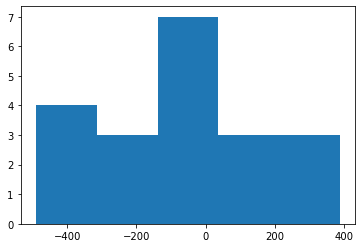

In [162]:
plt.hist(all_preds3-cl2, bins=5)
plt.show()

In [174]:
starting_time = time.time()
r = requests.get(url="https://api-pub.bitfinex.com/v2/candles/trade:1m:tBTCUSD/hist")
data9 = r.json()
df9 = pd.DataFrame(data9, columns=["time", "open", "close", "high", "low", "volume"])
# Reverse dataframe so most recent time last
df9 = df9[::-1].reset_index()

# Transform data to correct shape
my_data = np.expand_dims(df9["close"][-20:], axis=0)
my_data = my_data.transpose()
p3 = data["column_scaler"]["close"].transform(my_data)
p4 = np.expand_dims(p3, axis=0)
# Get prediction
ans = model.predict(p4)
# Unscale
ans2 = data["column_scaler"]["close"].inverse_transform(ans)
cl = df9.iloc[-1]['close']
p_cl = ans2[0][0]
print(f"Current Closing Price:   {cl:.2f}")
print()
print(f"Predicted Closing Price in 5 minutes: {p_cl:.2f}     Predicted Change: {p_cl - cl:.2f}")

print()

# Use the Monte Carlo method to make prediction with range
ans5, all_preds = MC_Drop_Pred(p3, trials=1000)
ans6 = data["column_scaler"]["close"].inverse_transform(ans5.reshape(1, -1))
cl2 = df9.iloc[-1]['close']
p_cl2 = ans6[0][0]

all_preds2 = []
above, below = 0, 0
for i in all_preds:
    all_preds2.append(i[0])
all_preds3 = data["column_scaler"]["close"].inverse_transform(all_preds2)
print(f"Monte Carlo Mean Prediction: {all_preds3.mean():.2f}     Predicted Change: {all_preds3.mean() - cl2:.2f}     Std Dev: {all_preds3.std():.2f}")

all_preds4 = all_preds3 - cl2
above, below = 0, 0

for i in all_preds4:
    if i[0] > 0:
        above += 1
    else:
        below += 1
print(f"Percent of positive Monte Carlo results: {100 * above / (above + below)}%")
print(f"operation took {time.time() - starting_time:.2f} seconds")

Current Closing Price:   44711.00

Predicted Closing Price in 5 minutes: 44761.20     Predicted Change: 50.20

Monte Carlo Mean Prediction: 44758.16     Predicted Change: 47.16     Std Dev: 284.82
Percent of positive Monte Carlo results: 56.9%
operation took 27.18 seconds


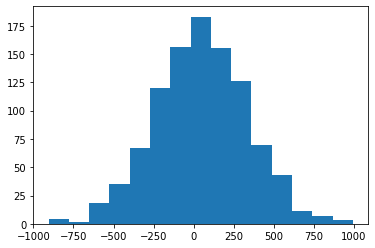

In [179]:
plt.hist(all_preds3-cl2, bins=15)
plt.show()